In [59]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [61]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                               ])


transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

In [62]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [63]:
# Corrected im_convert function
def im_convert(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    return image

In [64]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

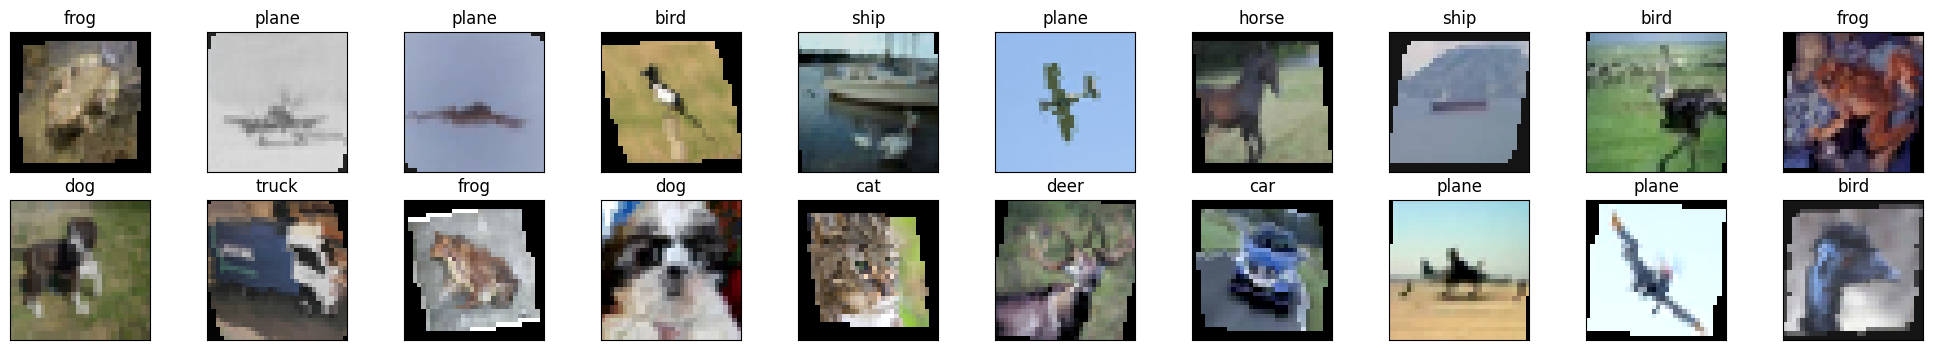

In [65]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [66]:
# formula for calculating height and widths:
# Output width: (W_in - kernel_size + 2 * padding) / stride + 1 = (W_in - 3 + 2 * 1) / 1 + 1 = W_in
# Output height: (H_in - kernel_size + 2 * padding) / stride + 1 = (H_in - 3 + 2 * 1) / 1 + 1 = H_in
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)

      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [67]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [69]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0

    test_running_loss = 0.0
    test_running_corrects = 0.0

    for inputs, labels in training_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)


    else:
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)

                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)

                _, test_preds = torch.max(test_outputs, 1)
                test_running_loss += test_loss.item()
                test_running_corrects += torch.sum(test_preds == test_labels.data)

        epoch_loss = running_loss / len(training_loader)
        epoch_accuracy = running_corrects.float() / len(training_loader)

        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_accuracy)
        # ==========================//test//======================
        test_epoch_loss = test_running_loss / len(test_loader)
        test_epoch_accuracy = test_running_corrects.float() / len(test_loader)

        test_running_loss_history.append(test_epoch_loss)
        test_running_corrects_history.append(test_epoch_accuracy)

        print(f'epoch {e + 1}')
        print('training loss:{:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_accuracy.item()))
        print('test loss:{:.4f}, test accuracy {:.4f}'.format(test_epoch_loss, test_epoch_accuracy.item()))

epoch 1
training loss:1.7047, accuracy 37.4780
test loss:1.4373, test accuracy 47.6700
epoch 2
training loss:1.4143, accuracy 48.7420
test loss:1.2515, test accuracy 54.5600
epoch 3
training loss:1.2748, accuracy 54.1120
test loss:1.1397, test accuracy 58.9600
epoch 4
training loss:1.1832, accuracy 57.9100
test loss:1.0624, test accuracy 63.2400
epoch 5
training loss:1.1107, accuracy 60.8220
test loss:0.9874, test accuracy 65.4800
epoch 6
training loss:1.0595, accuracy 62.4640
test loss:0.9671, test accuracy 66.1300
epoch 7
training loss:1.0190, accuracy 64.1660
test loss:0.9208, test accuracy 68.1700
epoch 8
training loss:0.9842, accuracy 65.4340
test loss:0.9056, test accuracy 68.6800
epoch 9
training loss:0.9615, accuracy 66.2440
test loss:0.8625, test accuracy 70.1100
epoch 10
training loss:0.9345, accuracy 67.3300
test loss:0.8609, test accuracy 70.3800
epoch 11
training loss:0.9100, accuracy 68.0760
test loss:0.8321, test accuracy 71.2200
epoch 12
training loss:0.8965, accuracy 6

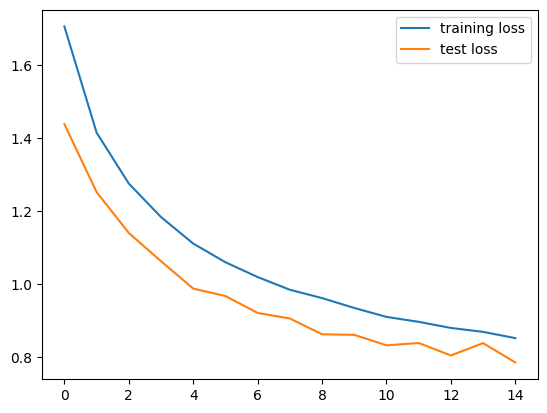

In [70]:
plt.plot(running_loss_history, label='training loss')
plt.plot(test_running_loss_history, label='test loss')
plt.legend()

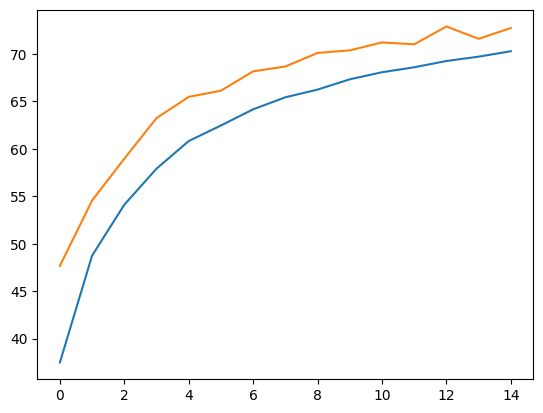

In [71]:
# Assuming running_corrects_history is a list of PyTorch tensors
# Convert and move tensors to CPU and then convert to NumPy arrays
running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]
test_running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in test_running_corrects_history]

plt.plot(running_corrects_history_numpy, label='accuracy')
plt.plot(test_running_corrects_history_numpy, label='test accuracy')


In [72]:
# saving the model

model_path = './trained-models/ConvNet-Model-CIFAR10'
torch.save(model.state_dict(), model_path)

In [73]:
# loading the model
# model = LeNet().to(device)
# model_path = './trained-model/first-model'
# model.load_state_dict(torch.load(model_path))

In [77]:
# import requests
# from PIL import Image
# import PIL.ImageOps
# 
# url = ''
# 
# response = requests.get(url, stream=True)
# img = Image.open(response.raw)
# 
# img = transform(img)
# plt.imshow(im_convert(img))

In [78]:
# image = img.to(device).unsqueeze(0)
# 
# test_outputs = model(image)
# _, pred = torch.max(test_outputs, 1)
# print(classes[pred.item()])

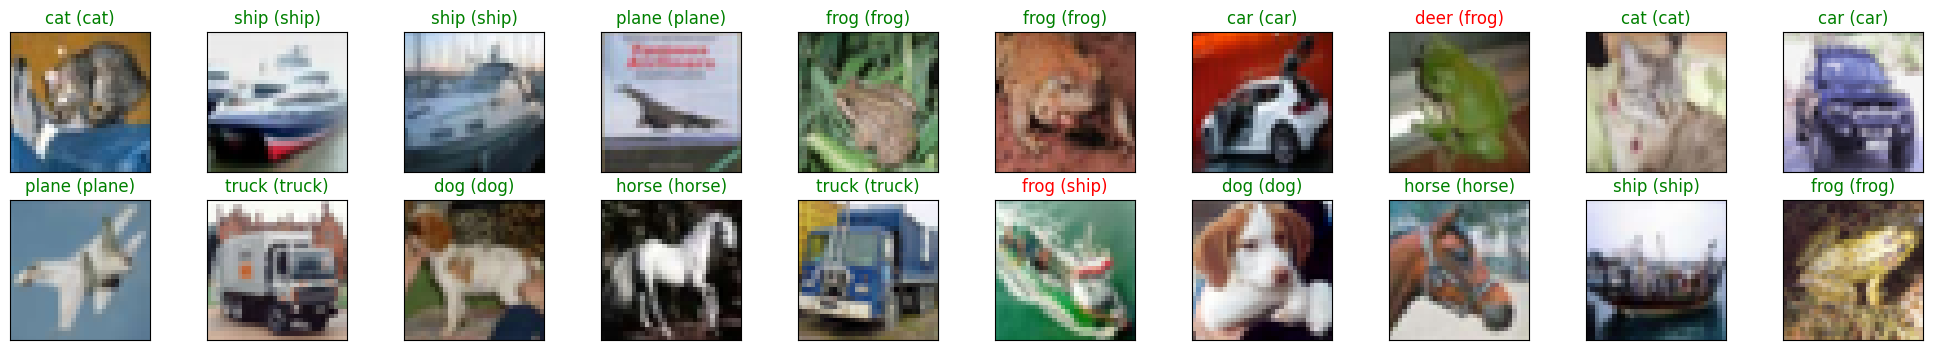

In [79]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

# running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]


for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(
        "{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
        color=('green' if preds[idx] == labels[idx] else "red"))